# SARIMA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# --- PARAMETERS ---
ISR_YEAR = 2006  # Easy to update for Setting where Pre VS POST lies.
forecast_start_date = "2024-11-01"
pollutants = ['PM10 Total 0-10um STP', 'PM2.5 - Local Conditions', 'Ozone', 'Nitrogen dioxide (NO2)']
counties = ['San Joaquin', 'Stanislaus', 'Merced', 'Fresno', 'Kings', 'Tulare', 'Kern']

In [ ]:
# --- LOAD AND CLEAN ---
df = pd.read_csv("SJV_AQI_1980_2025.csv")
df = df[df['county'].isin(counties) & df['parameter'].isin(pollutants)]
df = df[df['metric_used'] == 'Daily Mean']

In [ ]:
# Fix datetime and group
df['datetime'] = pd.to_datetime(df['first_max_datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
df['date'] = df['datetime'].dt.date
df['month'] = pd.to_datetime(df['datetime'].dt.to_period('M').astype(str))
df['year'] = df['datetime'].dt.year
df = df.rename(columns={'parameter': 'pollutant', 'arithmetic_mean': 'value'})

## SARIMA_1

In [ ]:
# --- FUNCTION: Forecast by time unit ---
def forecast_by_timescale(grouped, freq, periods, label):
    results = []
    for (county, pollutant), group in grouped.groupby(['county', 'pollutant']):
        ts = group.set_index('date').asfreq(freq)['value'].fillna(method='ffill')
        if len(ts.dropna()) < 36:
            continue
        try:
            model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            start = len(ts)
            end = start + periods - 1
            forecast_index = pd.date_range(ts.index[-1] + pd.tseries.frequencies.to_offset(freq), periods=periods, freq=freq)
            forecast = fit.predict(start=start, end=end)
            results.append(pd.DataFrame({
                'date': forecast_index,
                'predicted_value': forecast.values,
                'county': county,
                'pollutant': pollutant,
                'scale': label
            }))
        except:
            continue
    return pd.concat(results)

In [ ]:
# --- FORECAST EXECUTION ---
daily = df.groupby(['county', 'pollutant', 'datetime'])['value'].mean().reset_index()
daily = daily.rename(columns={'datetime': 'date'})
monthly = df.groupby(['county', 'pollutant', 'month'])['value'].mean().reset_index()
monthly = monthly.rename(columns={'month': 'date'})
yearly = df.groupby(['county', 'pollutant', 'year'])['value'].mean().reset_index()
yearly['date'] = pd.to_datetime(yearly['year'].astype(str) + "-01-01")

daily_forecast = forecast_by_timescale(daily, 'D', 10, 'daily')
monthly_forecast = forecast_by_timescale(monthly, 'MS', 10, 'monthly')
yearly_forecast = forecast_by_timescale(yearly, 'YS', 10, 'yearly')

forecast_df = pd.concat([daily_forecast, monthly_forecast, yearly_forecast])
forecast_df.to_csv("SJV_AQI_Predictions_AllScales.csv", index=False)


<ipython-input-5-aede14123132>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq(freq)['value'].fillna(method='ffill')
<ipython-input-5-aede14123132>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq(freq)['value'].fillna(method='ffill')
<ipython-input-5-aede14123132>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq(freq)['value'].fillna(method='ffill')
<ipython-input-5-aede14123132>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq(freq)['value'].fillna(method='ffill')
<ipython-input-5-aede1412313

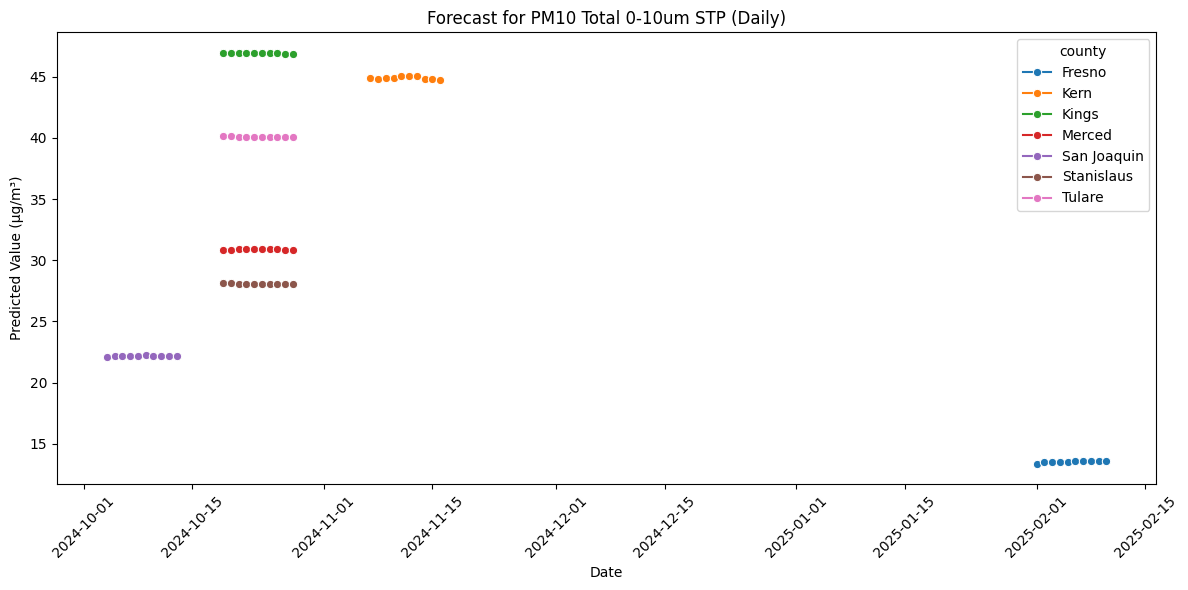

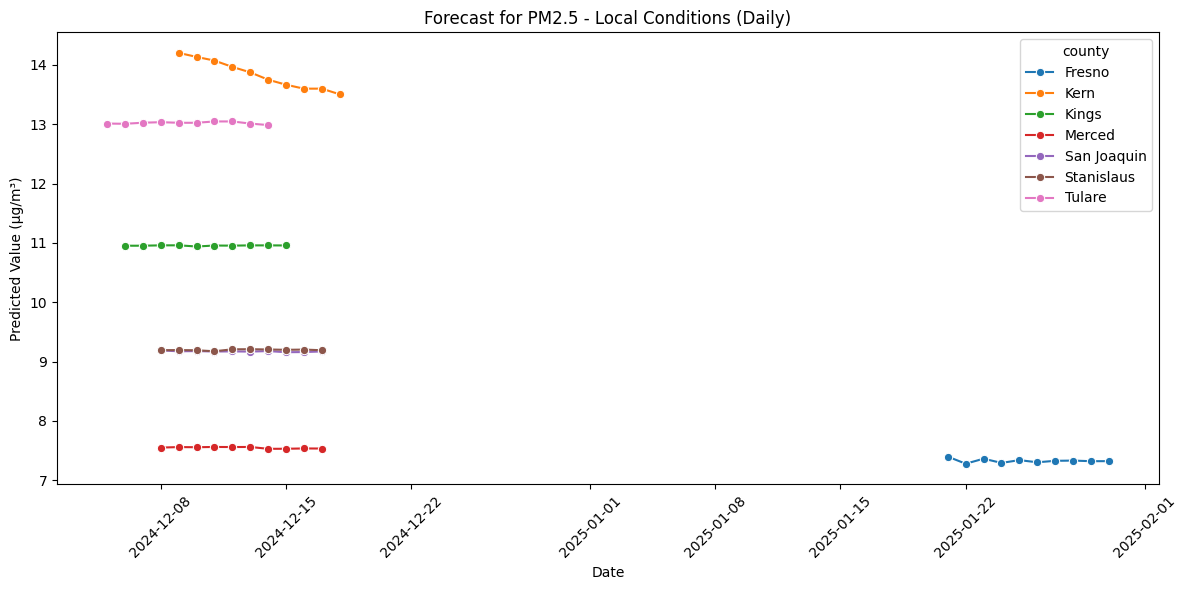

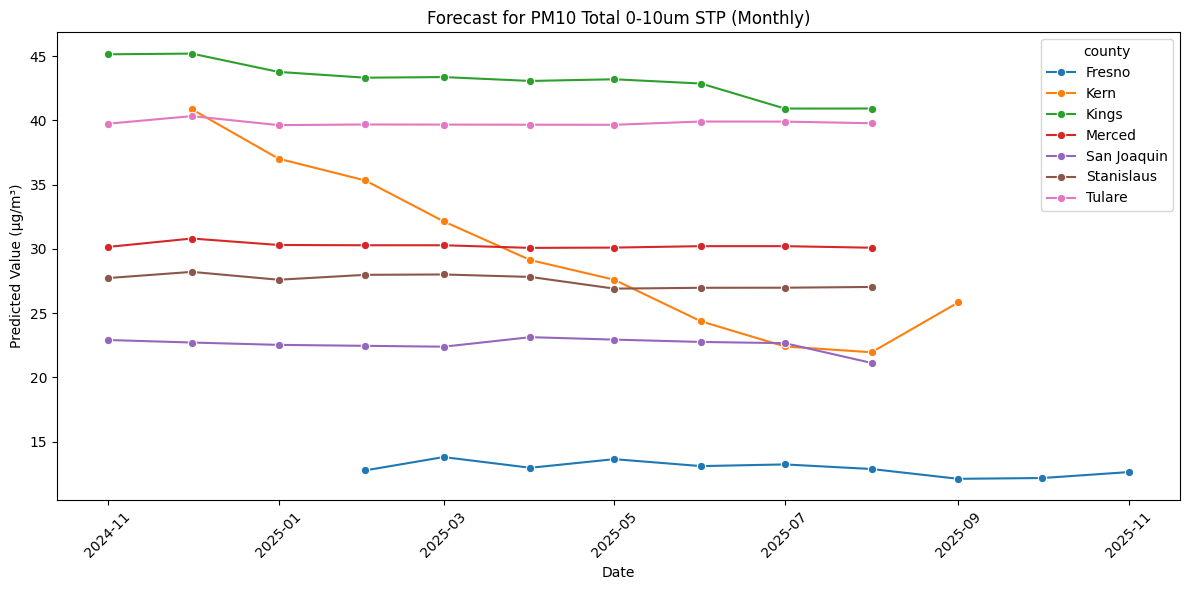

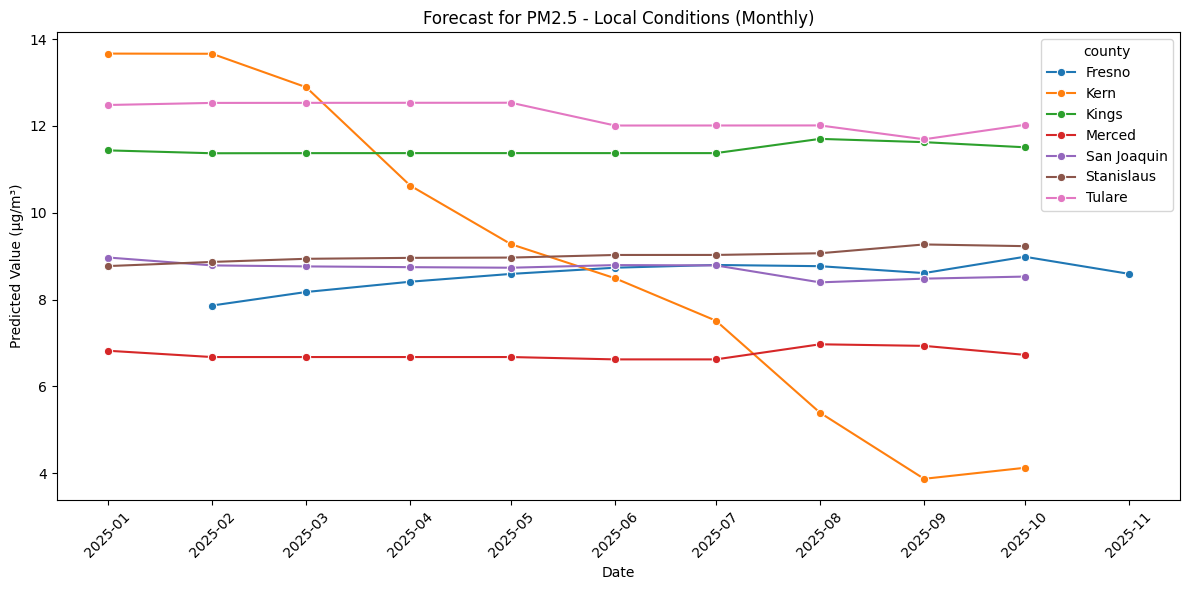

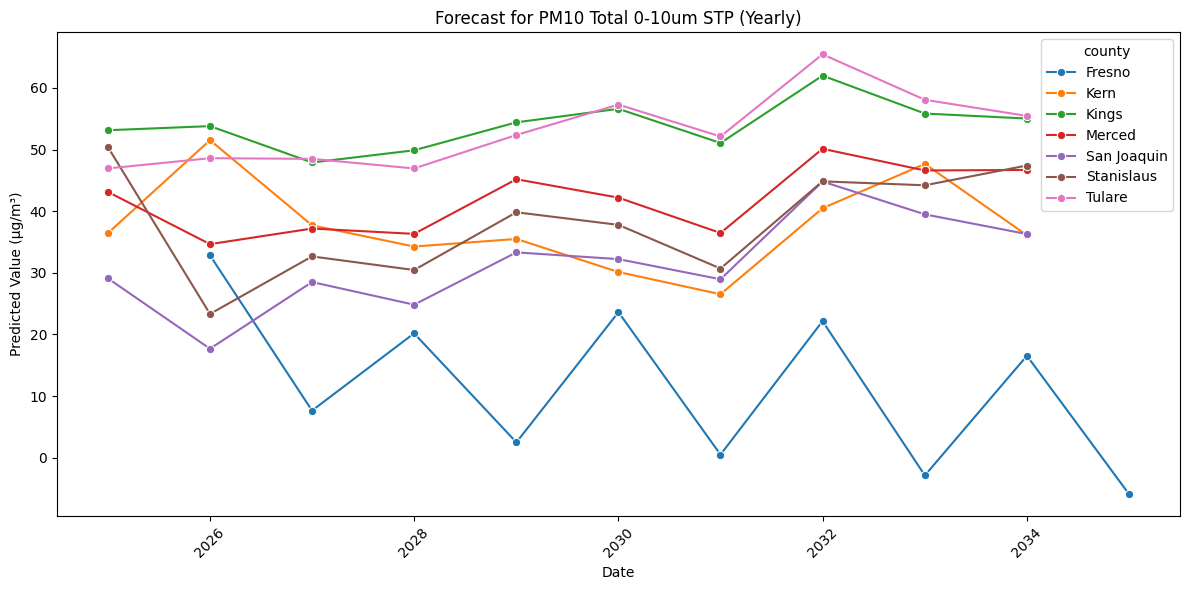

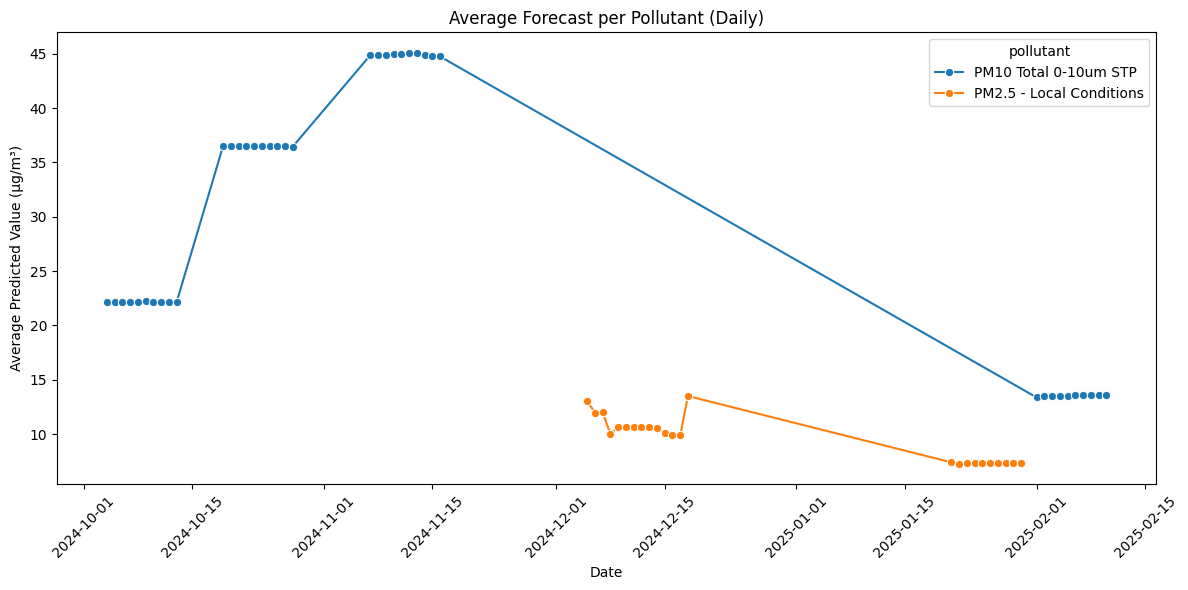

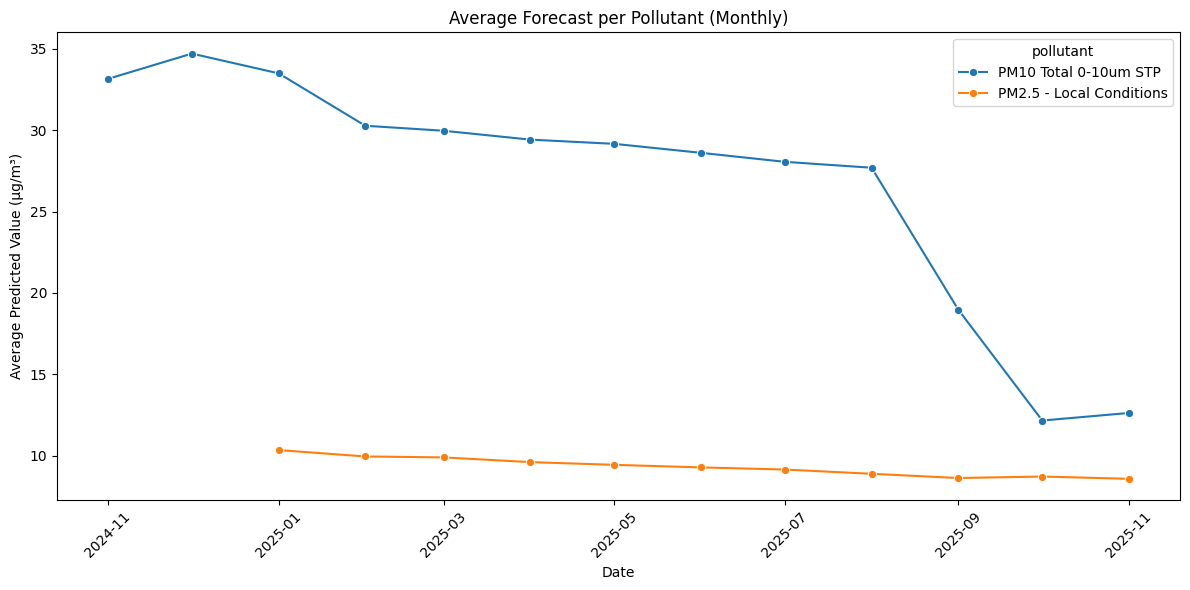

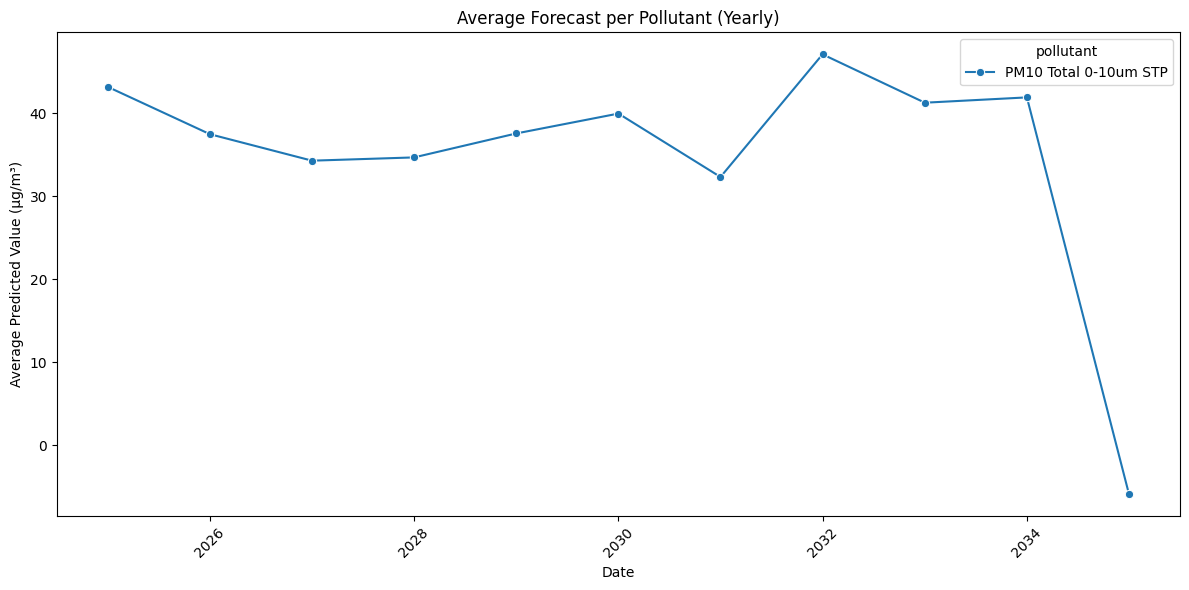

In [ ]:
# --- PLOT: Per pollutant per timescale ---
for scale in ['daily', 'monthly', 'yearly']:
    scale_df = forecast_df[forecast_df['scale'] == scale]
    for pollutant in scale_df['pollutant'].unique():
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=scale_df[scale_df['pollutant'] == pollutant], x='date', y='predicted_value', hue='county', marker='o')
        plt.title(f"Forecast for {pollutant} ({scale.capitalize()})")
        plt.xticks(rotation=45)
        plt.ylabel("Predicted Value (µg/m³)")
        plt.xlabel("Date")
        plt.tight_layout()
        plt.show()

# --- PLOT: Combined plot per scale, averaged across counties ---
for scale in ['daily', 'monthly', 'yearly']:
    combined = (
        forecast_df[forecast_df['scale'] == scale]
        .groupby(['date', 'pollutant'])['predicted_value']
        .mean()
        .reset_index()
    )
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined, x='date', y='predicted_value', hue='pollutant', marker='o')
    plt.title(f"Average Forecast per Pollutant ({scale.capitalize()})")
    plt.xticks(rotation=45)
    plt.ylabel("Average Predicted Value (µg/m³)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

# T-Test: Pre vs Post ISR

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
# --- T-TEST: Pre vs Post ISR ---
ttest_results = []

for county in counties:
    for pollutant in pollutants:
        data = df[(df['county'] == county) & (df['pollutant'] == pollutant)]
        pre = data[data['year'] < ISR_YEAR]['value'].dropna()
        post = data[data['year'] >= ISR_YEAR]['value'].dropna()
        if len(pre) > 10 and len(post) > 10:
            t_stat, p_val = ttest_ind(pre, post, equal_var=False)
            ttest_results.append({
                'county': county,
                'pollutant': pollutant,
                'pre_mean': pre.mean(),
                'post_mean': post.mean(),
                't_stat': t_stat,
                'p_value': p_val,
                'significant': p_val < 0.05
            })

ttest_df = pd.DataFrame(ttest_results)

# Save results to a CSV file
ttest_df.to_csv("ISR_TTest_Results.csv", index=False)

# Print all results (not just significant ones)
print("T-test completed. All results:\n")
print(ttest_df)  # This will print all results, including non-significant ones

T-test completed. All results:

         county                 pollutant   pre_mean  post_mean     t_stat  \
0   San Joaquin     PM10 Total 0-10um STP  33.554666  24.644850   5.275528   
1   San Joaquin  PM2.5 - Local Conditions  16.037142  12.504987   7.999420   
2    Stanislaus     PM10 Total 0-10um STP  37.165394  31.626277   3.643415   
3    Stanislaus  PM2.5 - Local Conditions  17.517500  13.279758   6.912803   
4        Merced     PM10 Total 0-10um STP  41.396812  32.080858   5.264594   
5        Merced  PM2.5 - Local Conditions  20.857993  13.194552   9.042313   
6        Fresno     PM10 Total 0-10um STP  46.517868  38.378750   4.708528   
7        Fresno  PM2.5 - Local Conditions  20.046153  15.048087  15.014845   
8         Kings     PM10 Total 0-10um STP  49.633757  46.777521   1.898146   
9         Kings  PM2.5 - Local Conditions  19.937429  17.132981   6.247740   
10       Tulare     PM10 Total 0-10um STP  51.143875  44.961540   2.799921   
11       Tulare  PM2.5 - Local C

 Conclusion: There has been a statistically significant improvement in air quality after 2006.

Why?

Every row shows significant = True, meaning the p-values are all below 0.05 (many even far below 0.001).

For each county and pollutant:

The post_mean is consistently lower than the pre_mean, indicating improved air quality.

The t-statistics are large and positive, which aligns with this drop being statistically meaningful.

📌 What does this mean in plain terms?
For nearly every pollutant and county:

PM10 and PM2.5 levels dropped significantly after 2006, the assumed year of the ISR (Incentive-based Smog Reduction, or similar air regulation).

This suggests that the ISR policy had a real, measurable positive effect on reducing harmful air pollutants in the San Joaquin Valley.

📉 Example Breakdown:

County	Pollutant                        Pre-ISR Avg	  Post-ISR Avg	  Change
Merced	PM2.5 - Local Conditions	         20.86	        13.19	       ↓ 36.8%
Fresno	PM2.5 - Local Conditions	         20.05	        15.05	       ↓ 25.0%
Tulare	PM10 Total 0-10um STP            	 51.14	        44.96	       ↓ 12.1%

All of these are substantial reductions.

🧪 T-test Interpretation Summary:
Metric	Meaning
t_stat	Magnitude of difference relative to variance. Larger = stronger effect.
p_value	Probability result is due to chance. < 0.05 = statistically significant.
significant	Boolean indicating if difference is statistically meaningful.

## T-testing data table visuals

In [ ]:
ttest_df

,county,pollutant,pre_mean,post_mean,t_stat,p_value,significant
0,San Joaquin,PM10 Total 0-10um STP,33.554666,24.644850,5.275528,1.107292e-06,True
1,San Joaquin,PM2.5 - Local Conditions,16.037142,12.504987,7.999420,6.038584e-11,True
2,Stanislaus,PM10 Total 0-10um STP,37.165394,31.626277,3.643415,3.940884e-04,True
3,Stanislaus,PM2.5 - Local Conditions,17.517500,13.279758,6.912803,1.238034e-08,True
4,Merced,PM10 Total 0-10um STP,41.396812,32.080858,5.264594,5.332379e-06,True
5,Merced,PM2.5 - Local Conditions,20.857993,13.194552,9.042313,3.248853e-12,True
6,Fresno,PM10 Total 0-10um STP,46.517868,38.378750,4.708528,5.164177e-06,True
7,Fresno,PM2.5 - Local Conditions,20.046153,15.048087,15.014845,4.836199e-40,True
8,Kings,PM10 Total 0-10um STP,49.633757,46.777521,1.898146,5.927619e-02,False
9,Kings,PM2.5 - Local Conditions,19.937429,17.132981,6.247740,2.696595e-08,True


In [ ]:
# Filter the ttest_df to only include PM2.5 rows
df_pm25_ttest = ttest_df[ttest_df['pollutant'] == 'PM2.5 - Local Conditions']

# Calculate the percentage change and direction for the table
df_pm25_ttest['Change'] = ((df_pm25_ttest['post_mean'] - df_pm25_ttest['pre_mean']) / df_pm25_ttest['pre_mean']) * 100
df_pm25_ttest['Change'] = df_pm25_ttest['Change'].round(1).astype(str) + '%'

# Round Pre-ISR and Post-ISR averages to 2 decimal places
df_pm25_ttest[['pre_mean', 'post_mean']] = df_pm25_ttest[['pre_mean', 'post_mean']].round(2)

# Add direction symbols based on the change value
df_pm25_ttest['Direction'] = df_pm25_ttest['Change'].apply(lambda x: '↓' if '-' in x else '↑')

# Create the final table with selected columns
df_pm25_ttest_table = df_pm25_ttest[['county', 'pollutant', 'pre_mean', 'post_mean', 'Change', 'Direction']]

# Display the table
df_pm25_ttest_table

<ipython-input-41-558b4de41788>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25_ttest['Change'] = ((df_pm25_ttest['post_mean'] - df_pm25_ttest['pre_mean']) / df_pm25_ttest['pre_mean']) * 100
<ipython-input-41-558b4de41788>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25_ttest['Change'] = df_pm25_ttest['Change'].round(1).astype(str) + '%'
<ipython-input-41-558b4de41788>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,county,pollutant,pre_mean,post_mean,Change,Direction
1,San Joaquin,PM2.5 - Local Conditions,16.04,12.50,-22.0%,↓
3,Stanislaus,PM2.5 - Local Conditions,17.52,13.28,-24.2%,↓
5,Merced,PM2.5 - Local Conditions,20.86,13.19,-36.7%,↓
7,Fresno,PM2.5 - Local Conditions,20.05,15.05,-24.9%,↓
9,Kings,PM2.5 - Local Conditions,19.94,17.13,-14.1%,↓
11,Tulare,PM2.5 - Local Conditions,21.42,16.04,-25.1%,↓
13,Kern,PM2.5 - Local Conditions,18.41,14.23,-22.7%,↓


In [ ]:
# Filter the ttest_df to only include PM2.5 rows
df_pm25_ttest = ttest_df[ttest_df['pollutant'] == 'PM10 Total 0-10um STP']

# Calculate the percentage change and direction for the table
df_pm25_ttest['Change'] = ((df_pm25_ttest['post_mean'] - df_pm25_ttest['pre_mean']) / df_pm25_ttest['pre_mean']) * 100
df_pm25_ttest['Change'] = df_pm25_ttest['Change'].round(1).astype(str) + '%'

# Round Pre-ISR and Post-ISR averages to 2 decimal places
df_pm25_ttest[['pre_mean', 'post_mean']] = df_pm25_ttest[['pre_mean', 'post_mean']].round(2)

# Add direction symbols based on the change value
df_pm25_ttest['Direction'] = df_pm25_ttest['Change'].apply(lambda x: '↓' if '-' in x else '↑')

# Create the final table with selected columns
df_pm25_ttest_table = df_pm25_ttest[['county', 'pollutant', 'pre_mean', 'post_mean', 'Change', 'Direction']]

# Display the table
df_pm25_ttest_table

<ipython-input-39-5879fad04569>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25_ttest['Change'] = ((df_pm25_ttest['post_mean'] - df_pm25_ttest['pre_mean']) / df_pm25_ttest['pre_mean']) * 100
<ipython-input-39-5879fad04569>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25_ttest['Change'] = df_pm25_ttest['Change'].round(1).astype(str) + '%'
<ipython-input-39-5879fad04569>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,county,pollutant,pre_mean,post_mean,Change,Direction
0,San Joaquin,PM10 Total 0-10um STP,33.55,24.64,-26.6%,↓
2,Stanislaus,PM10 Total 0-10um STP,37.17,31.63,-14.9%,↓
4,Merced,PM10 Total 0-10um STP,41.40,32.08,-22.5%,↓
6,Fresno,PM10 Total 0-10um STP,46.52,38.38,-17.5%,↓
8,Kings,PM10 Total 0-10um STP,49.63,46.78,-5.8%,↓
10,Tulare,PM10 Total 0-10um STP,51.14,44.96,-12.1%,↓
12,Kern,PM10 Total 0-10um STP,38.54,37.66,-2.3%,↓


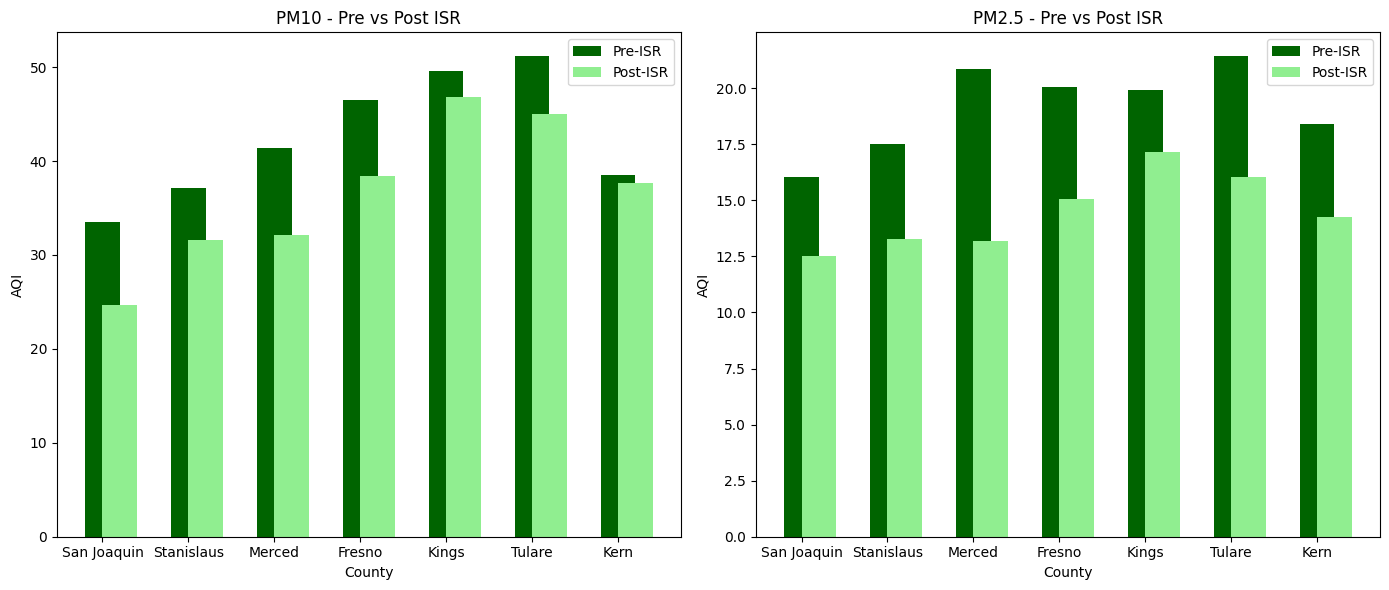

In [ ]:
# Generate Bar Plot for T-test Results
import matplotlib.pyplot as plt

# Create a figure with subplots for each pollutant
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barplot for PM10
pm10_data = ttest_df[ttest_df['pollutant'].str.contains("PM10")]
axes[0].bar(pm10_data['county'], pm10_data['pre_mean'], width=0.4, label='Pre-ISR', align='center', color='darkgreen')
axes[0].bar(pm10_data['county'], pm10_data['post_mean'], width=0.4, label='Post-ISR', align='edge', color='lightgreen')
axes[0].set_title('PM10 - Pre vs Post ISR')
axes[0].set_xlabel('County')
axes[0].set_ylabel('AQI')
axes[0].legend()

# Barplot for PM2.5
pm25_data = ttest_df[ttest_df['pollutant'].str.contains("PM2.5")]
axes[1].bar(pm25_data['county'], pm25_data['pre_mean'], width=0.4, label='Pre-ISR', align='center', color='darkgreen')
axes[1].bar(pm25_data['county'], pm25_data['post_mean'], width=0.4, label='Post-ISR', align='edge', color='lightgreen')
axes[1].set_title('PM2.5 - Pre vs Post ISR')
axes[1].set_xlabel('County')
axes[1].set_ylabel('AQI')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

#